<a href="https://colab.research.google.com/github/iCarrrot/nn_sudoku_project/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Befor start: runtime -> change runtime type -> GPU

In [1]:
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm


try:
    from src.net import Net, train, test, get_dataloader
    from src.preprocessing import Deskewing,  split_into_cells
    from src.util import check_sudoku, sudoku, sudoku2, get_pics_path, get_gray_images
    
except ModuleNotFoundError:
    import httpimport
    with httpimport.github_repo(
            'iCarrrot', 
            'nn_sudoku_project',
            module='src',
            branch='master'
    ):
        from src.net import Net, train, test, get_dataloader
        from src.preprocessing import Deskewing,  split_into_cells
        from src.util import check_sudoku, sudoku, sudoku2, get_pics_path, get_gray_images




Populating the interactive namespace from numpy and matplotlib


### TODO

* dzielenie datasetu
* downsampling obrazków
* metoda szybko printująca obrazek
* wycinanie diagramu z modyfikowanym thresholdem
* spięcie całości w metodę
* cięcie diagramu
* import sieci do rozpoznawania liczb
* konsumpcja outputu sieci

* solver: https://towardsdatascience.com/solving-sudoku-with-convolution-neural-network-keras-655ba4be3b11 
* solving krok po kroku: RNN?
* jakies ładne ogarnięcie całości

In [2]:
pics_path = get_pics_path()
gray_images = get_gray_images(pics_path)
gray_images.shape

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


(101, 4160, 3120)

## Dataset

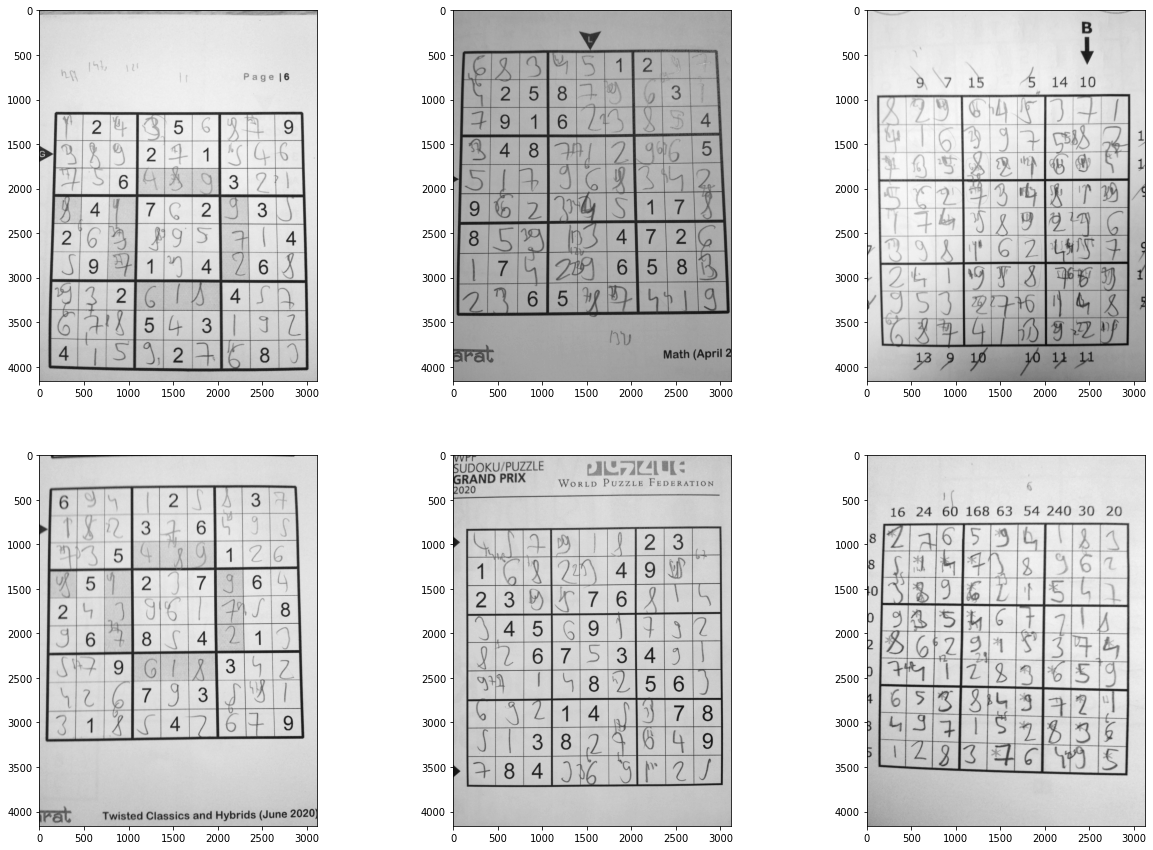

In [3]:
plt.figure(figsize=(21, 15))
for idx, img in enumerate(gray_images[np.random.choice(gray_images.shape[0], size=6)]):
    plt.subplot(2, 3, idx + 1)
    imgplot = plt.imshow(img, cmap='gray')
plt.show()


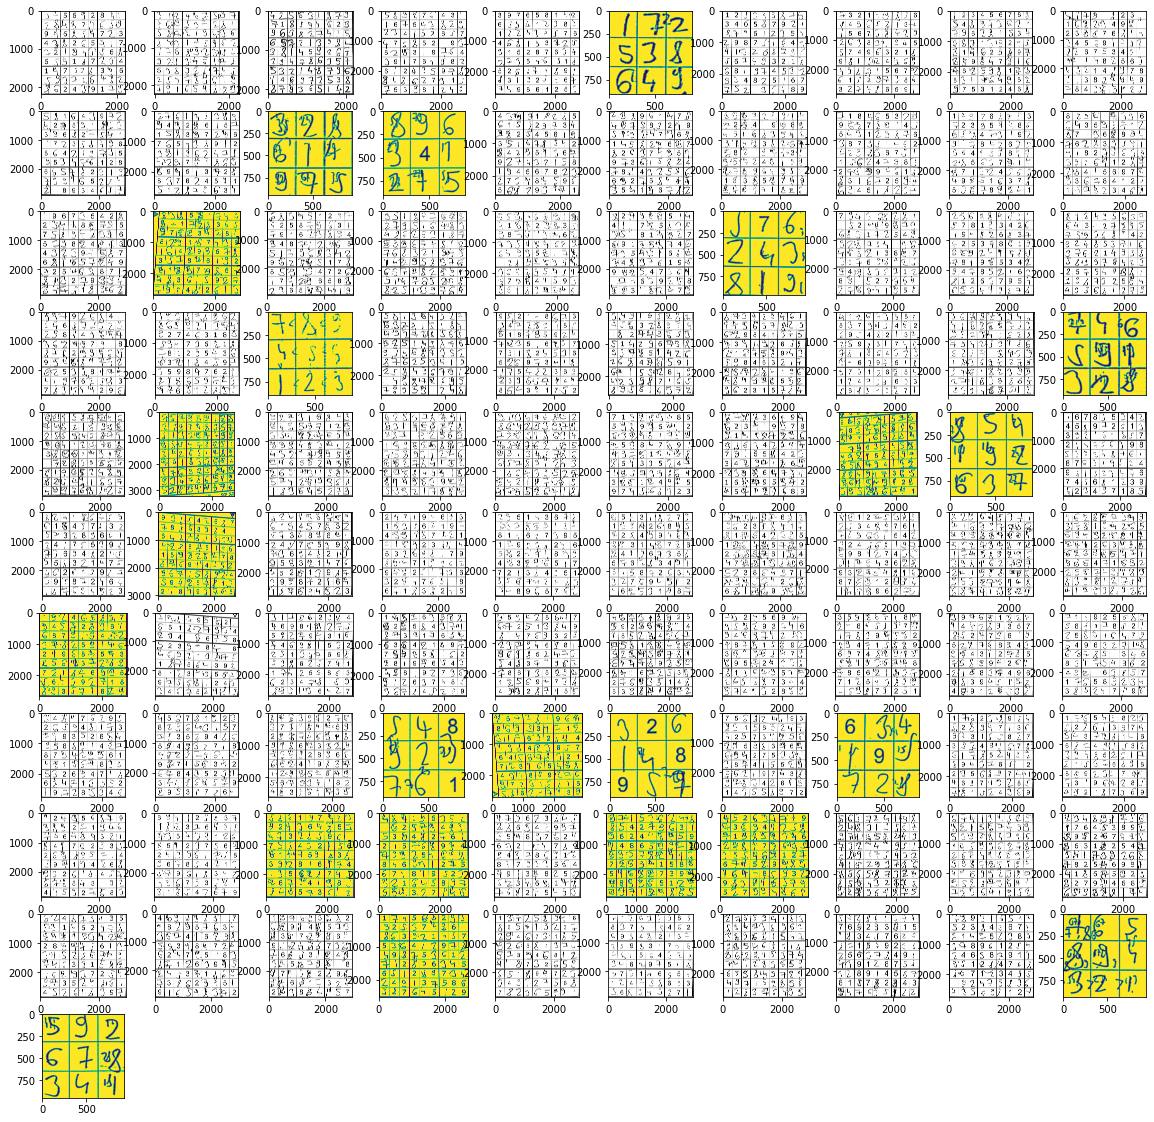

In [4]:
deskewed_imgs = []
plt.figure(figsize=(20, 20))
for i in tqdm(range(len(gray_images))):
    deskewed = Deskewing(gray_images[i])._deskew()
    plt.subplot(11, 10, i + 1)
    if deskewed.shape[0] < 2000 or deskewed.shape[1] < 2000 or abs(deskewed.shape[0] - deskewed.shape[1]) > 100:
        plt.imshow(deskewed)
    else:
        plt.imshow(deskewed, cmap='gray')
        
    deskewed_imgs.append(deskewed)

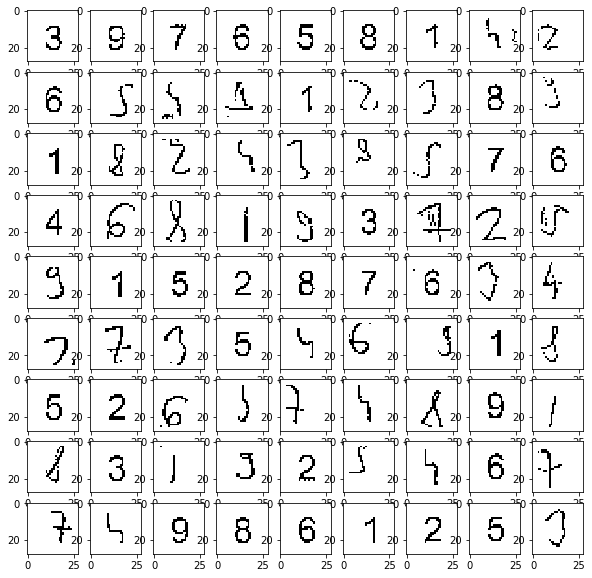

In [31]:
digits = split_into_cells(deskewed_imgs[4])
plt.figure(figsize=(10,10))
for i in range(81):
    plt.subplot(9, 9, i + 1)
    plt.imshow(digits[i, :, :], cmap='gray', interpolation='none')



## Example NN
[PyTorch MNIST](https://github.com/pytorch/examples/blob/master/mnist/main.py)

In [61]:
import torch
import torchvision


n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)



# y = np.array([ 
#     [2,3,8,9,6,1,4,7,5], 
#     [4,6,7,5,8,3,2,1,9], 
#     [5,1,9,2,4,7,3,6,8], 
#     [1,4,5,8,2,9,6,3,7], 
#     [8,2,6,3,7,4,9,5,1],
#     [9,7,3,6,1,5,8,2,4],
#     [7,8,1,4,3,2,5,9,6], 
#     [6,9,2,7,5,8,1,4,3], 
#     [3,5,4,1,9,6,7,8,2] ])


y = np.array([ 
    [3,9,7,6,5,8,1,4,2], 
    [6,5,4,7,1,2,3,8,9], 
    [1,8,2,4,3,9,5,7,6], 
    [4,6,8,1,9,3,7,2,5], 
    [9,1,5,2,8,7,6,3,4],
    [2,7,3,5,4,6,9,1,8],
    [5,2,6,3,7,4,8,9,1], 
    [8,3,1,9,2,5,4,6,7], 
    [7,4,9,8,6,1,2,5,3] ])

grid_dataloader = get_dataloader(digits, y, batch_size_test = batch_size_test , device='cuda')


model = Net()
model.to('cuda')

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [62]:
check_sudoku(y)

(True, <torch.utils.data.dataloader.DataLoader at 0x7f5bea2268d0>)

In [63]:
train(model=model, device='cuda', train_loader=train_loader, epoch=30, optimizer=torch.optim.Adam(model.parameters()))

Train Epoch: 30 [0/60000 (0%)]	Loss: 2.333410
Train Epoch: 30 [6400/60000 (11%)]	Loss: 0.361748
Train Epoch: 30 [12800/60000 (21%)]	Loss: 0.228978
Train Epoch: 30 [19200/60000 (32%)]	Loss: 0.214803
Train Epoch: 30 [25600/60000 (43%)]	Loss: 0.170283
Train Epoch: 30 [32000/60000 (53%)]	Loss: 0.094167
Train Epoch: 30 [38400/60000 (64%)]	Loss: 0.128375
Train Epoch: 30 [44800/60000 (75%)]	Loss: 0.030853
Train Epoch: 30 [51200/60000 (85%)]	Loss: 0.128287
Train Epoch: 30 [57600/60000 (96%)]	Loss: 0.067053


In [71]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            # print(pred.reshape((9,9)))
            correct += pred.eq(target.view_as(pred)).sum().item()


    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    if device != 'cpu':
        return pred.cpu().numpy()
    return pred.numpy()

prediction = test(model=model, device='cuda', test_loader=grid_dataloader)
equal = prediction.reshape((9,9)) == y 
print(equal.astype(int), equal.sum())


Test set: Average loss: 106.8249, Accuracy: 45/81 (56%)

[[1 1 1 1 1 0 1 0 0]
 [1 0 0 0 1 0 1 0 0]
 [1 1 1 0 0 0 1 1 0]
 [1 1 0 1 0 1 0 1 1]
 [0 1 1 1 1 1 0 0 1]
 [0 1 1 1 1 0 0 1 0]
 [1 1 0 0 0 0 0 1 0]
 [0 1 0 0 1 0 1 1 0]
 [0 1 0 1 1 1 1 1 1]] 45
